# *Official* Analysis of Cell Selectivity for Elevated Plus Maze (EPM).

#### *Note: Do not add "experimental" code/analysis to this notebook.*

In [1]:
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell
import os
import pandas as pd
import SigProc
import sys
import warnings

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
3. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
4. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
5. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
6. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
7. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


## Import the csv of raw neuron signal data into a pandas DataFrame, and run the data through the Dombeck 2007 signal rocessing algorithm.

##### Note: Recall that the raw neuron signal data for DRD77 and DRD73 must be downsampled by $2$.

In [4]:
drd87_data = pd.read_csv(raw_files[1], header=None)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(drd87_data, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[0], header=None)
drd87_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



## We compute the actual $\hat{D}$ values for all of the neuron column vectors in DRD87's `neuron_concated_behavior` dataframe

In [5]:
drd87_real_diff_vals = drd87_fe.set_real_diff_df(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
drd87_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:103: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
D,-4.19561,6.9537,5.86234,12.2911,7.6943,-1.0277,1.02405,-0.860894,-3.20938,2.44695,...,9.97405,-1.6101,6.50104,0.434317,5.00547,9.15386,5.86696,0.973809,-1.97104,13.037


## Now, we construct the permutation distributions of the $\hat{D}$ values, for each neuron column vector, from its values in a large number of resamples.
#### Note: use $1000$ resamples for preliminary analysis, and $\ge 10000$ for presentation/publication.

In [6]:
resampled_df = Resampler.shuffle(10000, drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")

## Next, we plot all the distribution of each neuron, after permutation resampling.

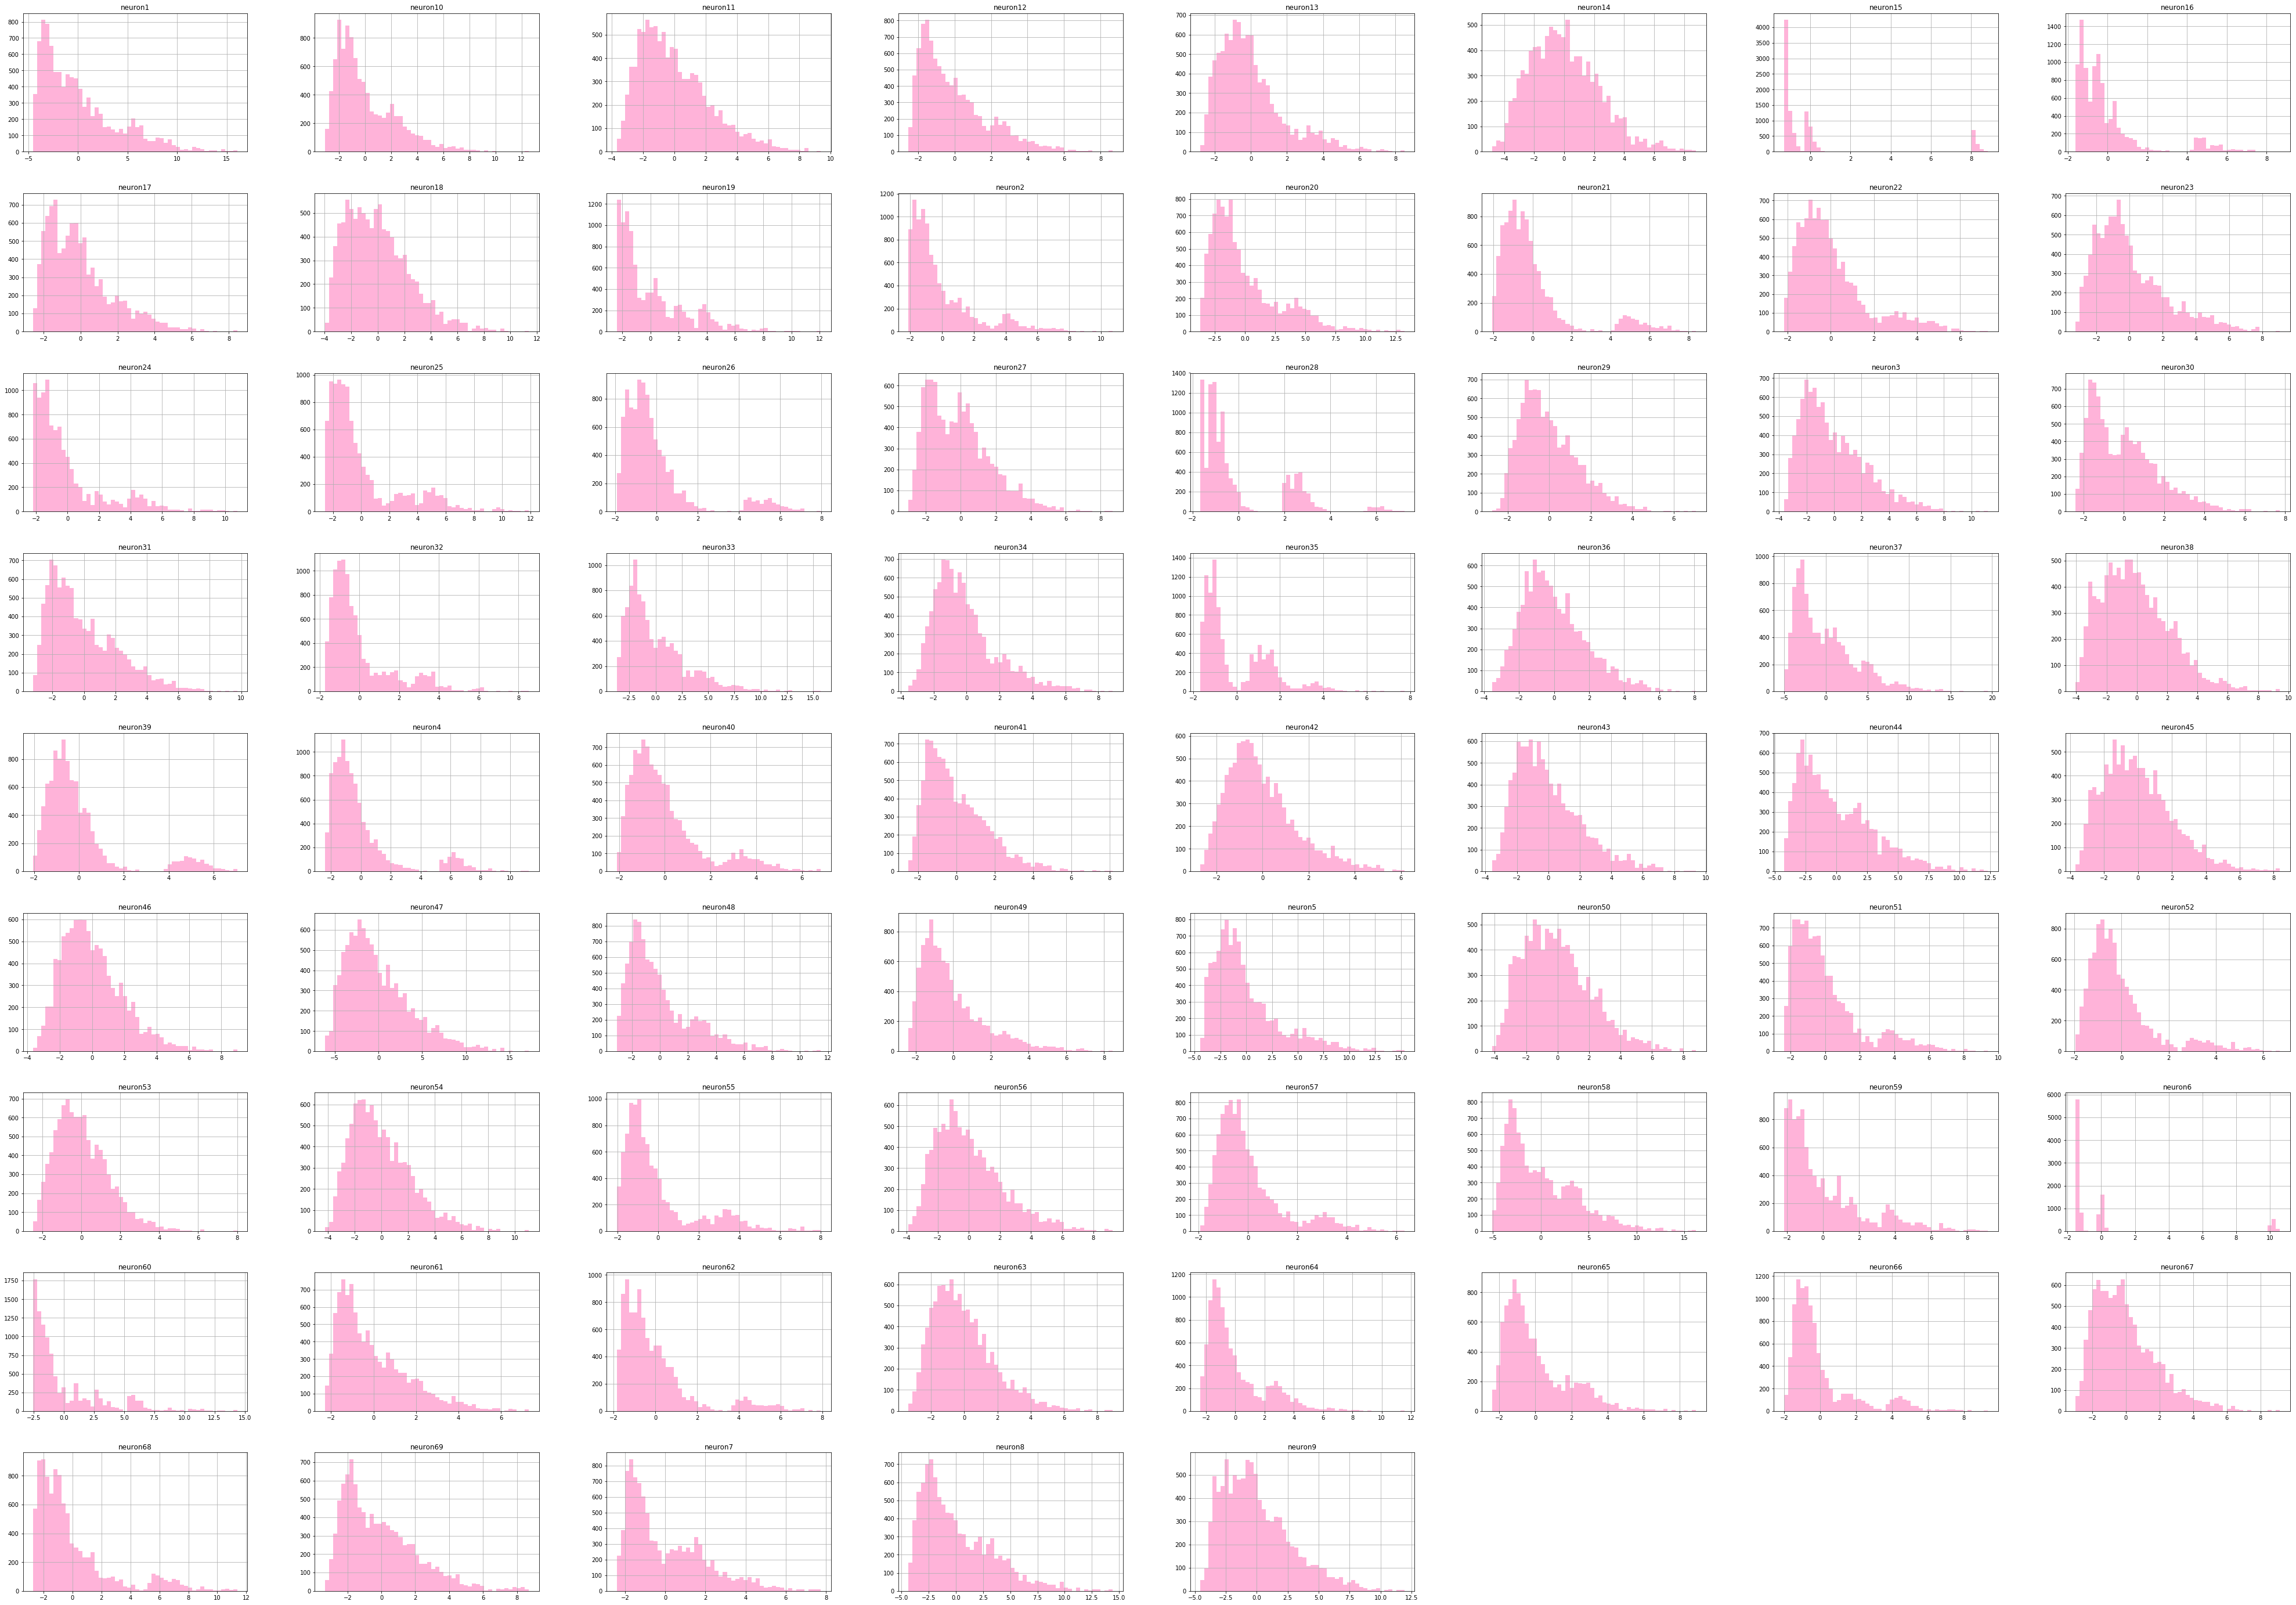

In [7]:
resampled_df.hist(alpha=0.5, color='hotpink', bins=50, figsize=(70, 50));

## We can see that almost all of the resampled (permutation) distributions are Gamma distributions. As a result, we must resort to a *non-parametric* test, i.e. the permutation test.

#### **Note**: 

> #### The $t$ test gives accurate $P$-values if the sampling distribution of the difference of means is at least roughly Normal. The permutation test gives accurate $P$-values even when the sampling distribution is not close to Normal. [16-45]()

> #### The permutation test is useful even if we plan to use the two-sample $t$ test. Rather than relying on Normal quantile plots of the two samples and the central limit theorem, we can directly check the Normality of the sampling distribution by looking at the permutation distribution. Permutation tests provide a “gold standard” for assessing two-sample $t$ tests. If the two $P$-values differ considerably, it usually indicates that the conditions for the two-sample $t$ don’t hold for these data. Because permutation tests give accurate $P$-values even when the sampling distribution is skewed, they are often used when accuracy is very important. [16-45]()

> #### When are permutation tests valid? The two-sample t test starts from the condition that the sampling distribution of $\bar{x}_1 − \bar{x}_2$ is Normal. This is the case if both populations have Normal distributions, and it is approximately true for large samples from non-Normal populations because of the central limit theorem. The central limit theorem helps explain the robustness of the two-sample $t$ test. The test works well when both populations are symmetric, especially when the two sample sizes are similar. [16-47]()

> #### The permutation test completely removes the Normality condition. *However, resampling in a way that moves observations between the two groups requires that the two populations are identical when the null hypothesis is true -- not only are their means the same, but also their spreads and shapes.* [16-47]()

### In the case of DRD87, in the EPM experiment), there are $4275$ observations in `ClosedArms_centerpoint` and $605$ observations in `OpenArms_centerpoint`. 
### We are interested in the following test statistic: $$\hat{D} = \texttt{mean}(X_O)− \texttt{mean}(X_C)$$, where $X_O$ are neuron signal values observed in `OpenArms_centerpoint`, and $X_C$ are are neuron signal values observed in `ClosedArms_centerpoint`.

### This gives us $\binom{4880}{605} = \frac{4880!}{605!4275!} \approx 10^{792}$ possible two-sample datasets (under the null hypothesis).

### **How rare is our result?**
> ### Namely, how many of these datasets have $|\texttt{mean}(X_O)− \texttt{mean}(X_C)| \ge \hat{D}$? What is the probability of seeing differences in the group means as extreme (or more extreme) than ours?

### We could consider each of the $\approx 10^{792}$ possible two-sample datasets (note that there are $\approx 10^{80}$ atoms in the observable universe), compute $|\texttt{mean}(X_O)− \texttt{mean}(X_C)|$ for each, and then compare to our original $\hat{D}$. Instead, we use a **permutation test**, which randomly samples from the $10^{792}$ possible two-sample datasets and estimates a $p$-value based on our original $\hat{D}$.

### **Permutation Principle**:
> ### If there were no difference in neuron activity in the OpenArms versus ClosedArms (null hypothesis), then all datasets obtained by randomly assigning the neuron signal data would have equal chance of being observed in the study.

### **Permutation test algorithm**:
> ###  For step $i = 1,2, \cdots ,p$:
> ### (1) Randomly assign neuron signal data points, while holding the behavior data points constant.
> ### (2) Compute $\hat{D}_i = \texttt{mean}(X_O,i)− \texttt{mean}(X_C,i)$, where $X_O,i$ are neuron signal data points in the `OpenArms_centerpoint` behavior in step $i$, and $X_C,i$ are neuron signal data points in the `ClosedArms_centerpoint` behavior in step $i$. 
### Finally, we utilize the function, `compute_two_side_p_val` to compute a (two-sided) $p$-value as follows: $$\frac{1}{p} \sum_{i=1}^{p} \mathbb{1}(|\hat{D}_i| \ge |\hat{D}|)$$

### **What are we actually testing?**
> ### Using the permutation test, we test the null hypothesis that the two samples are from the same distribution.
> ### How do we do this? Have we seen enough evidence (in the form of the observed difference between the sample means being large enough) to reject the null hypothesis that the two groups have identical probability distributions?

##### Sources:
- [STAT GU4206/GR5206 Statistical Computing & Introduction to Data Science. Grabriel Young, Columbia University]()

In [8]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_fe.auc_df, resampled_df, drd87_real_diff_vals, p_value=0.05, threshold=5)

## After classifying the neurons as either selective, not-selective, or unclassified, we perform a "deeper classification". Namely, we go through and classify each *selective* neuron with a $\hat{D} > 0$ as selective for `OpenArms_centerpoint`. Likewise, we go through and classify each *selective* neuron with a $\hat{D} < 0$ as selective for `ClosedArms_centerpoint`.

In [9]:
def deep_classify(classified_neurons, real_diff_vals):
    deeper_classification = classified_neurons.copy()

    for neuron in deeper_classification:
        if real_diff_vals[neuron].values > 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = "OpenArms_centerpoint"
        elif real_diff_vals[neuron].values < 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = "ClosedArms_centerpoint"
                
    return deeper_classification

In [10]:
import plotly
import plotly.graph_objs as go

def plot_pie_chart(dict_of_classifications, *labels):
    values = [sum([1 for classification in dict_of_classifications.values() if classification == "OpenArms_centerpoint"])]
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "ClosedArms_centerpoint"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "not-selective"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "unclassified"]))
    
    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace])

# Now, we will repeat the aforementioned procedure to classify the cells of DRD77, DRD73, and DRD46.

## We begin with DRD77.

In [11]:
drd77_data = pd.read_csv(raw_files[4], header=None)
drd77_data = FeatureExtractor.downsample_dataframe(drd77_data, 2)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(drd77_data, 2, 0.5, 0.2, 10)

behavior_df = pd.read_csv(raw_files[5], header=None)
drd77_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [12]:
drd77_real_diff_vals = drd77_fe.set_real_diff_df(drd77_fe.neuron_concated_behavior, drd77_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
drd77_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:103: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron21,neuron22,neuron23,neuron24,neuron25,neuron26,neuron27,neuron28,neuron29,neuron30
D,2.16483,5.05739,-0.859139,-0.289657,1.00619,2.58625,0.111218,8.48742,3.01192,3.18965,...,3.12089,6.62909,2.92575,-2.70131,0.776975,-4.81605,-0.619434,2.0976,1.7415,0.776975


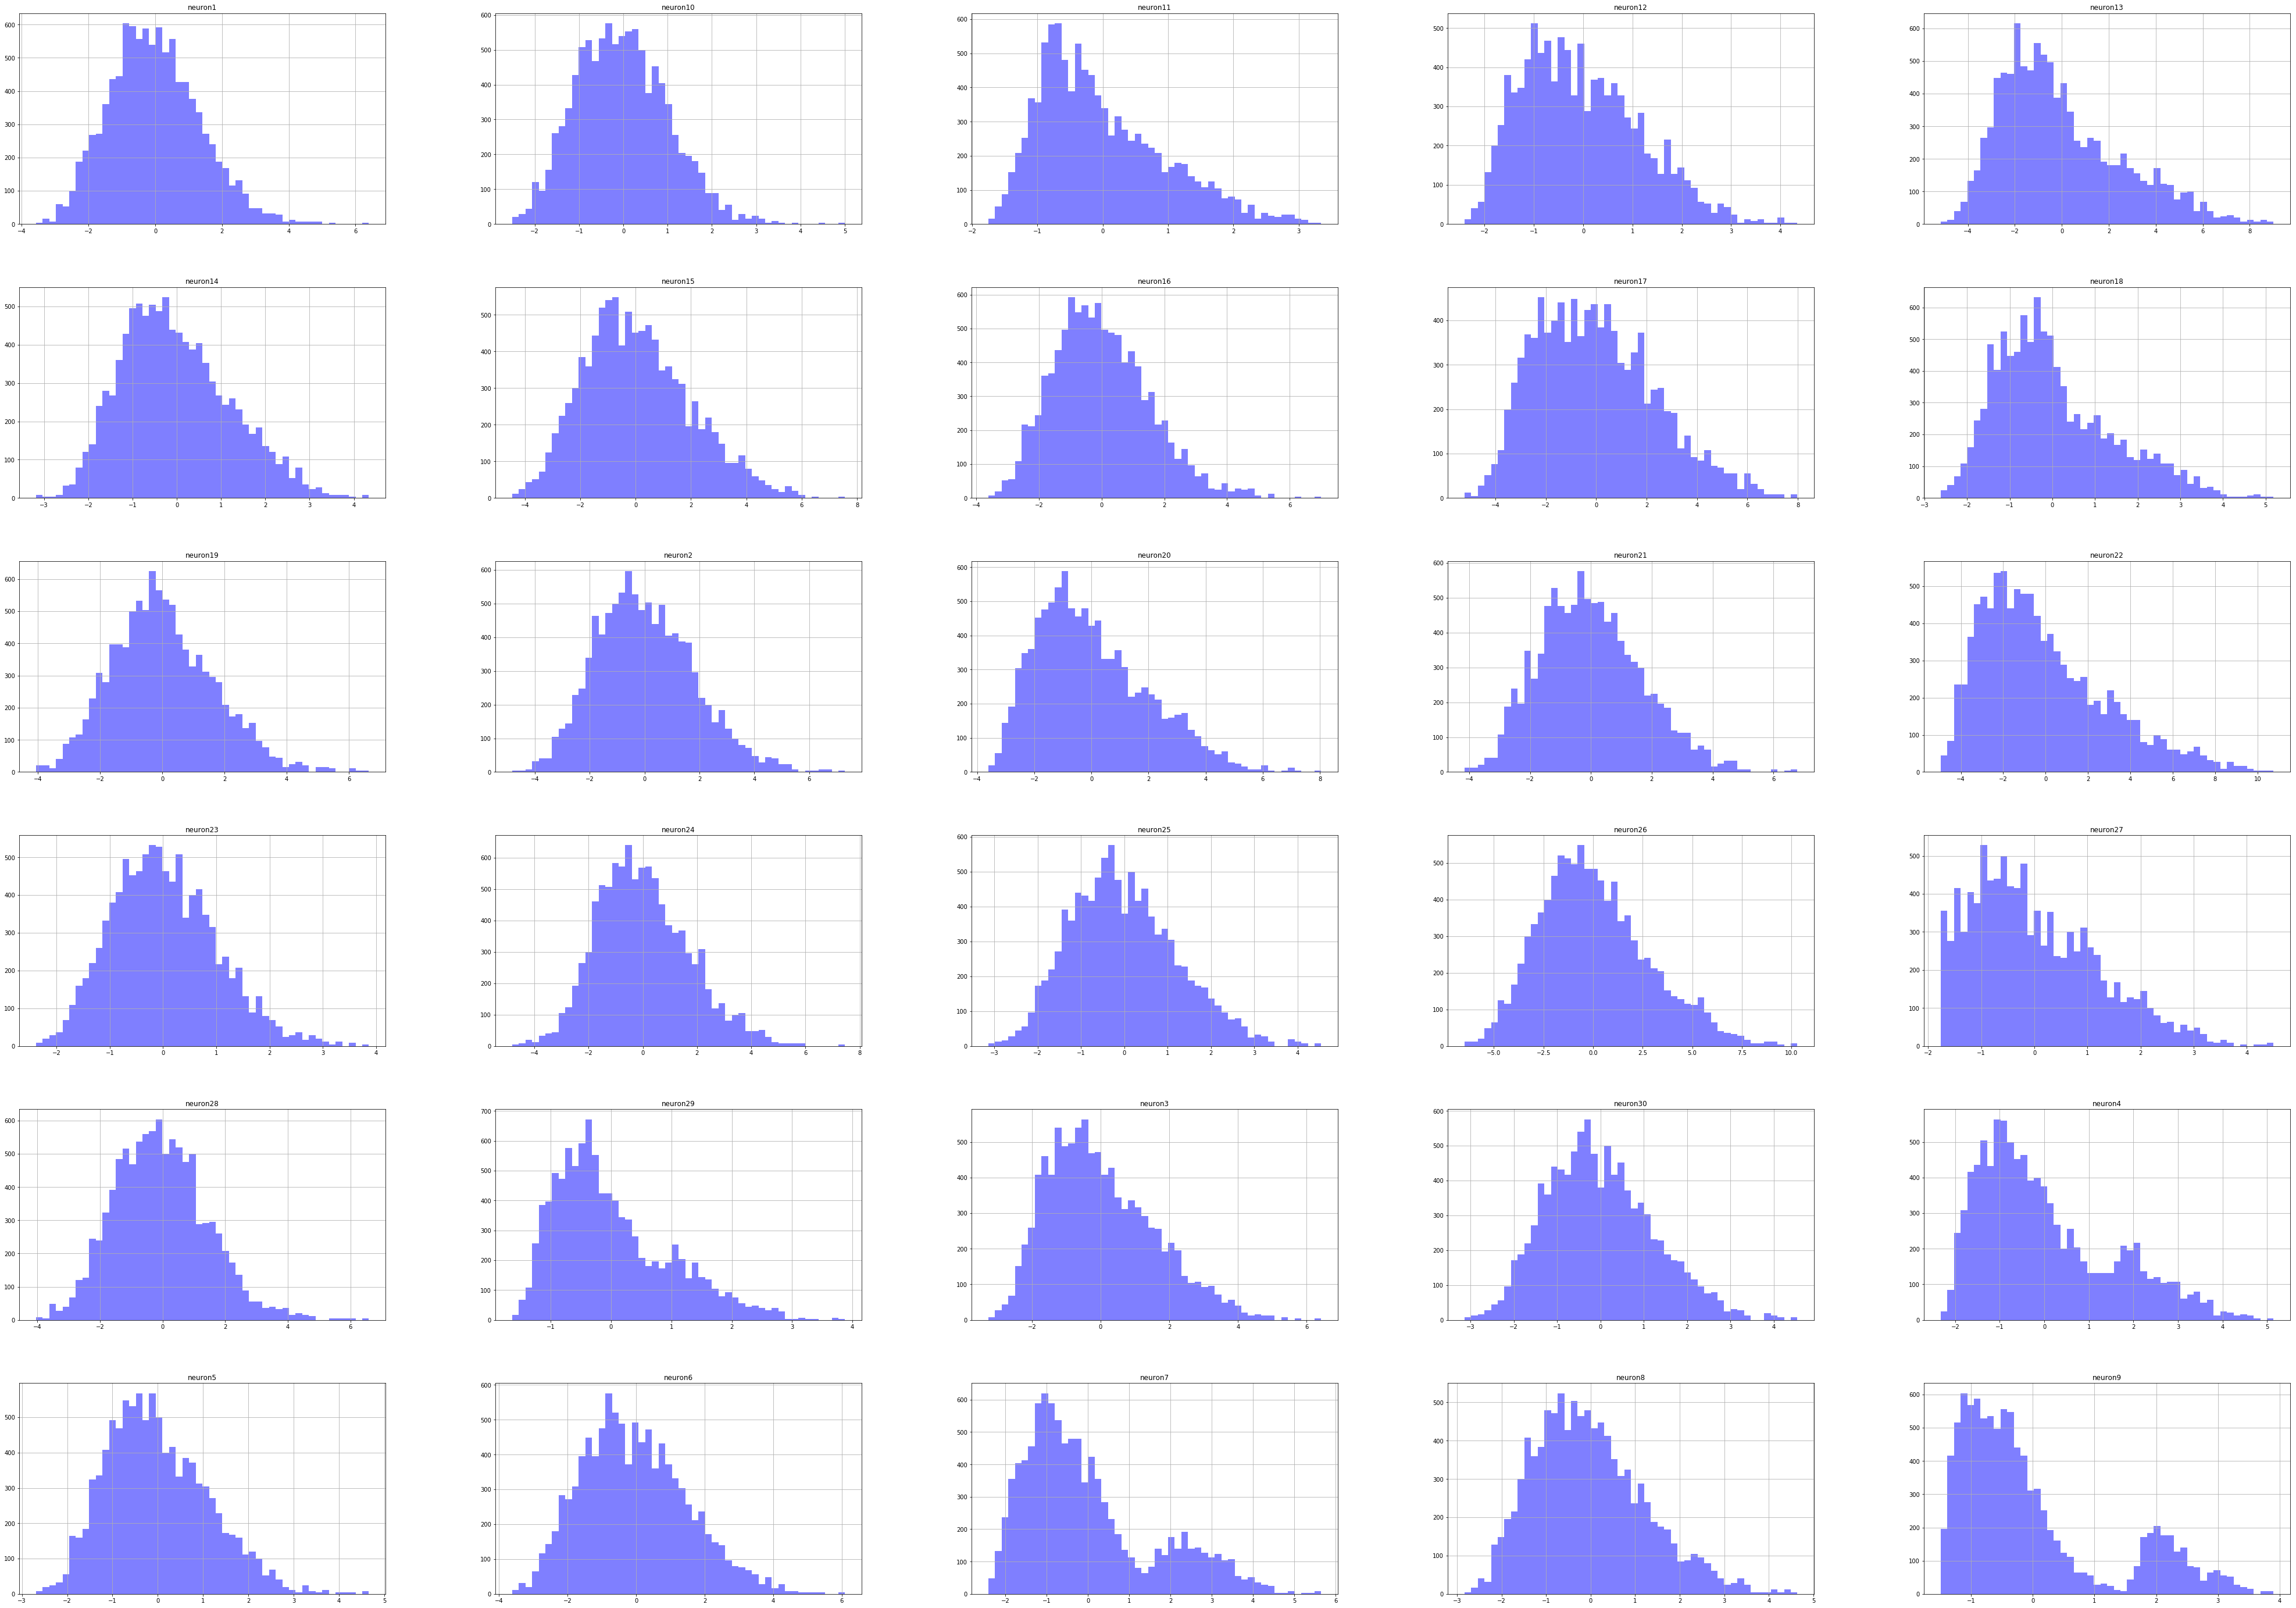

In [13]:
resampled_df = Resampler.shuffle(10000, drd77_fe.neuron_concated_behavior, drd77_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
resampled_df.hist(alpha=0.5, color='blue', bins=50, figsize=(70, 50));

In [14]:
drd77_classified_neurons = Resampler.non_normal_neuron_classifier(drd77_fe.auc_df, resampled_df, drd77_real_diff_vals, p_value=0.05, threshold=5)

## Now, DRD73.

In [15]:
drd73_data = pd.read_csv(raw_files[2], header=None)
drd73_data = FeatureExtractor.downsample_dataframe(drd73_data, 2)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(drd73_data, 2, 0.5, 0.2, 10)

behavior_df = pd.read_csv(raw_files[3], header=None)
drd73_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [16]:
drd73_real_diff_vals = drd73_fe.set_real_diff_df(drd73_fe.neuron_concated_behavior, drd73_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
drd73_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:103: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron19,neuron20,neuron21,neuron22,neuron23,neuron24,neuron25,neuron26,neuron27,neuron28
D,-2.34137,-3.23303,-2.25489,0.499955,-0.872401,3.91971,-0.197521,15.6549,0,-1.39292,...,-1.34295,-0.808848,0.867323,-1.16892,-4.22127,-0.348924,14.0445,8.02221,1.65689,-0.673152


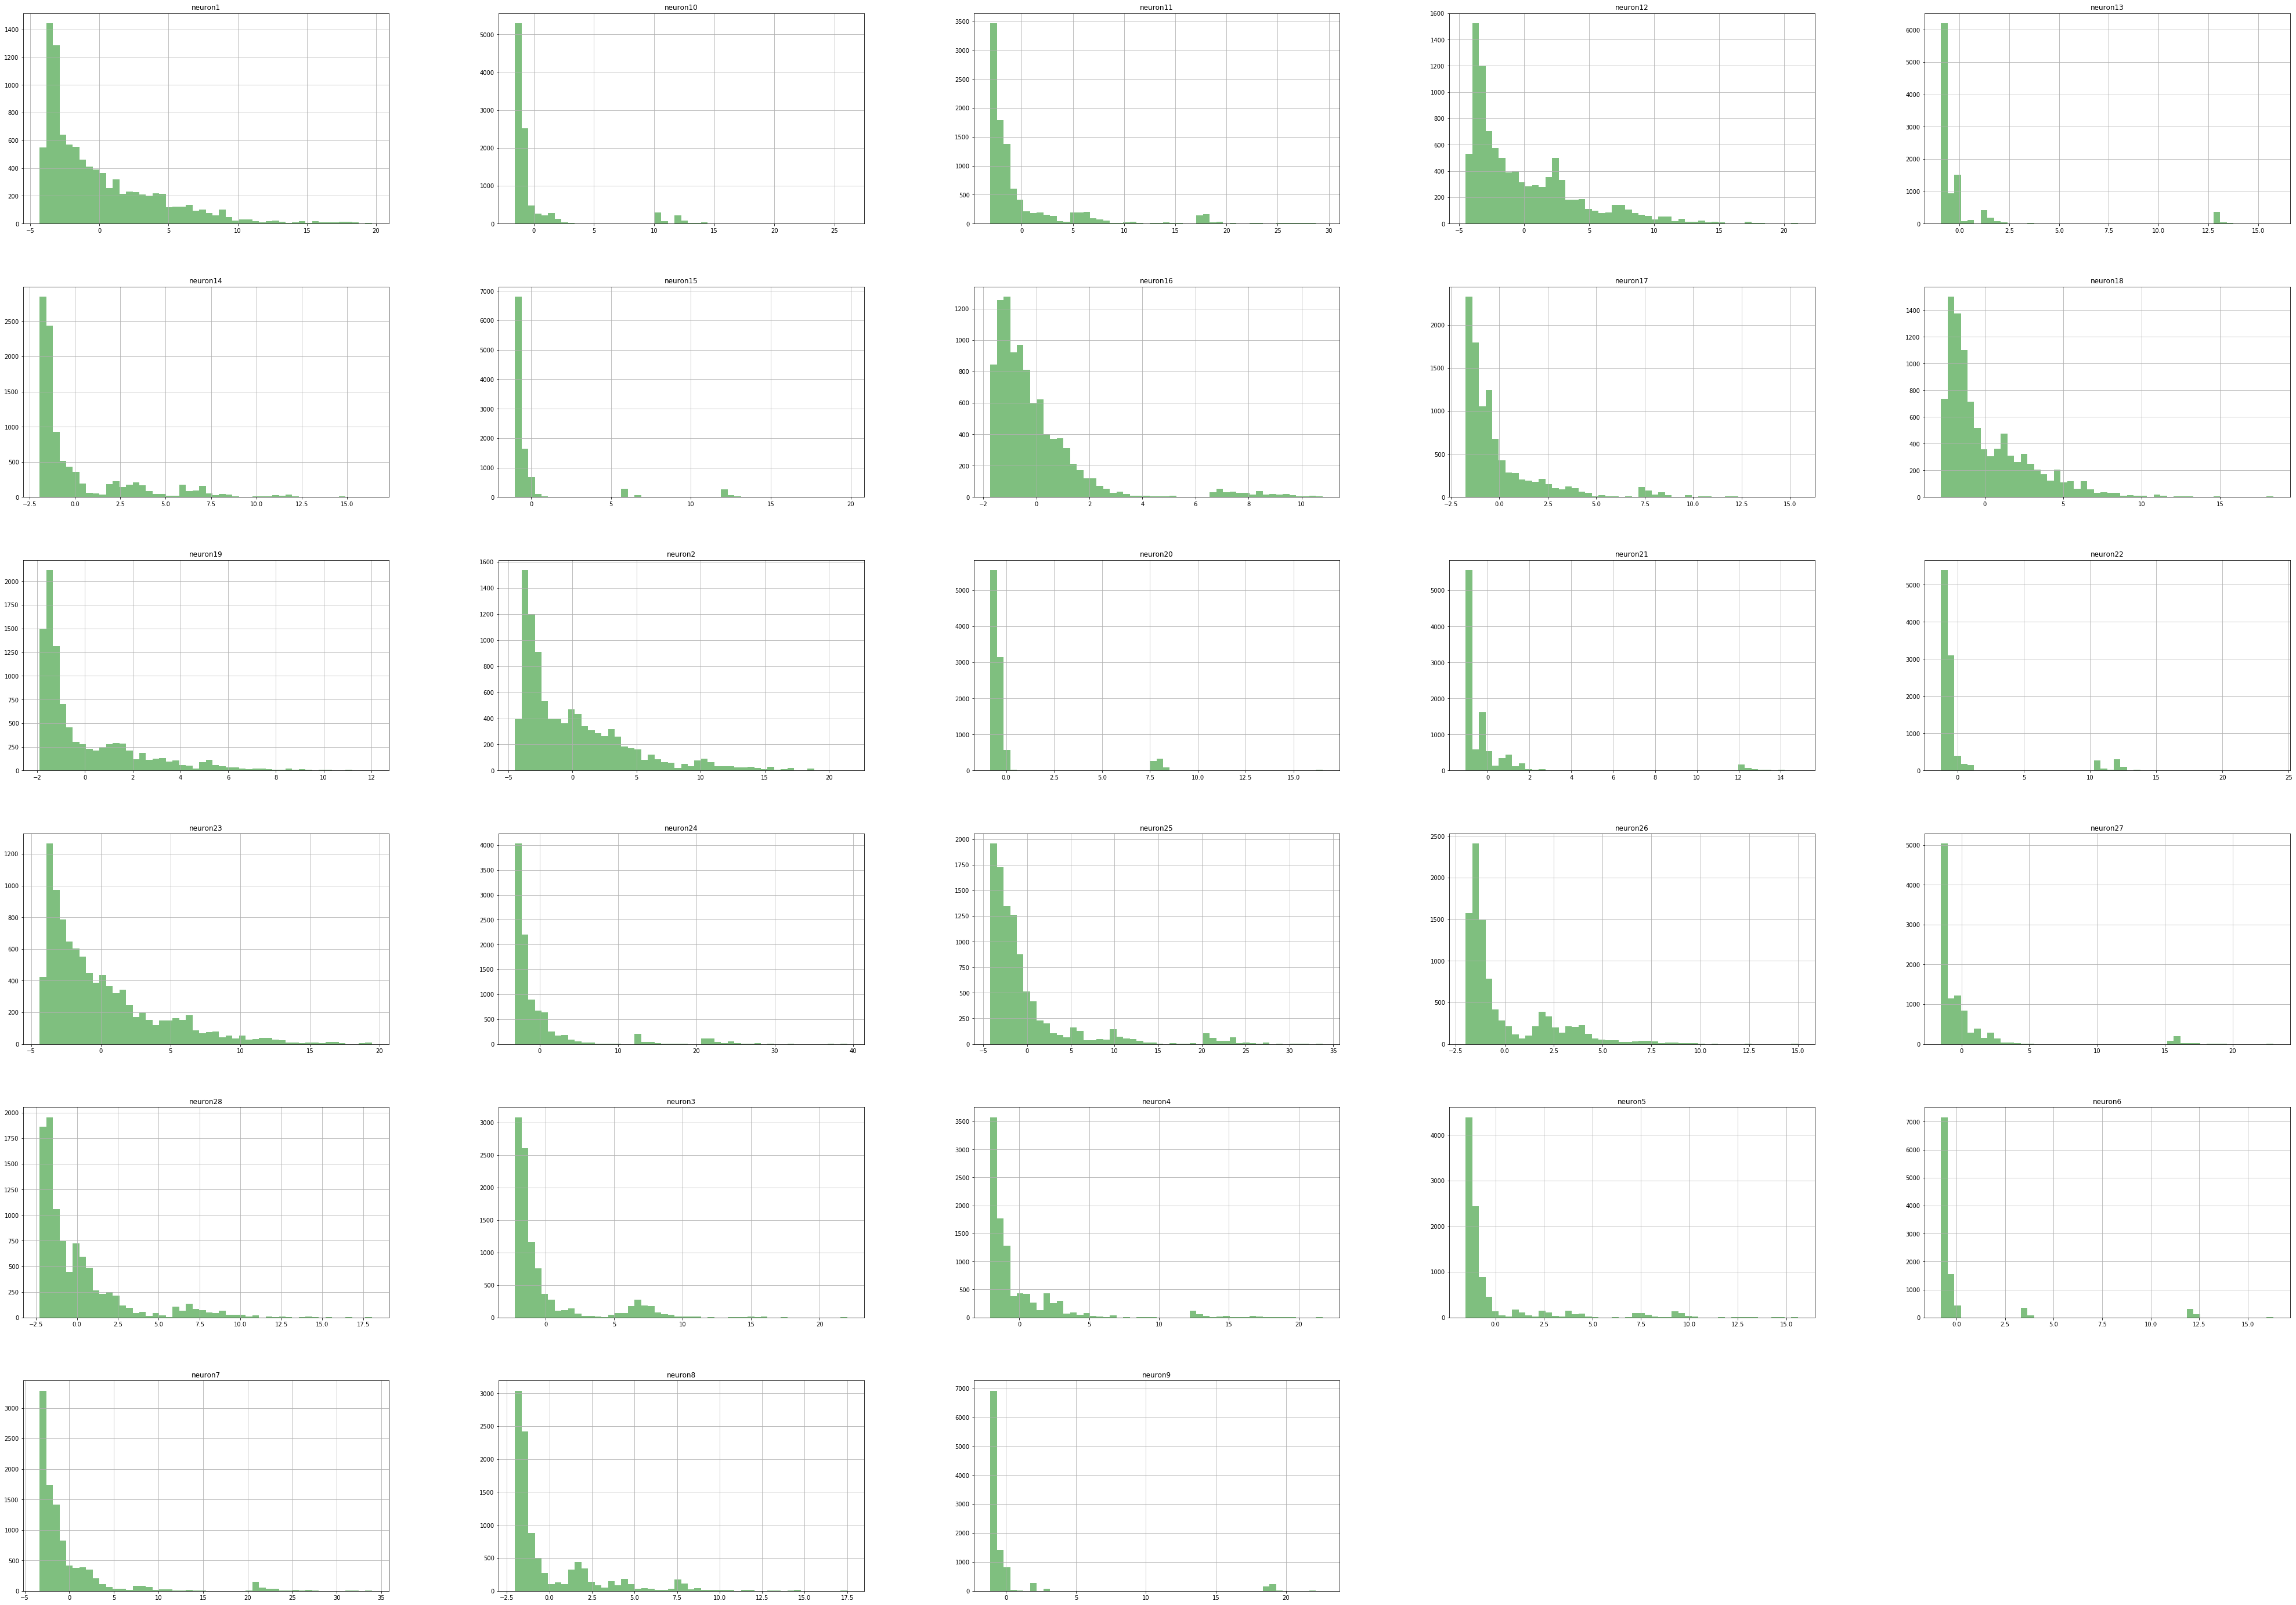

In [17]:
resampled_df = Resampler.shuffle(10000, drd73_fe.neuron_concated_behavior, drd73_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
resampled_df.hist(alpha=0.5, color='green', bins=50, figsize=(70, 50));

In [18]:
drd73_classified_neurons = Resampler.non_normal_neuron_classifier(drd73_fe.auc_df, resampled_df, drd73_real_diff_vals, p_value=0.05, threshold=5)

## Finally, DRD46.

In [19]:
drd46_data = pd.read_csv(raw_files[7], header=None)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(drd46_data, 2, 0.5, 0.2, 10)

behavior_df = pd.read_csv(raw_files[6], header=None)
drd46_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [20]:
drd46_real_diff_vals = drd46_fe.set_real_diff_df(drd46_fe.neuron_concated_behavior, drd46_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
drd46_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:103: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10
D,1.88941,6.89095,1.00182,0.982346,2.65844,1.93974,6.07983,-1.44679,-3.28795,-0.766029


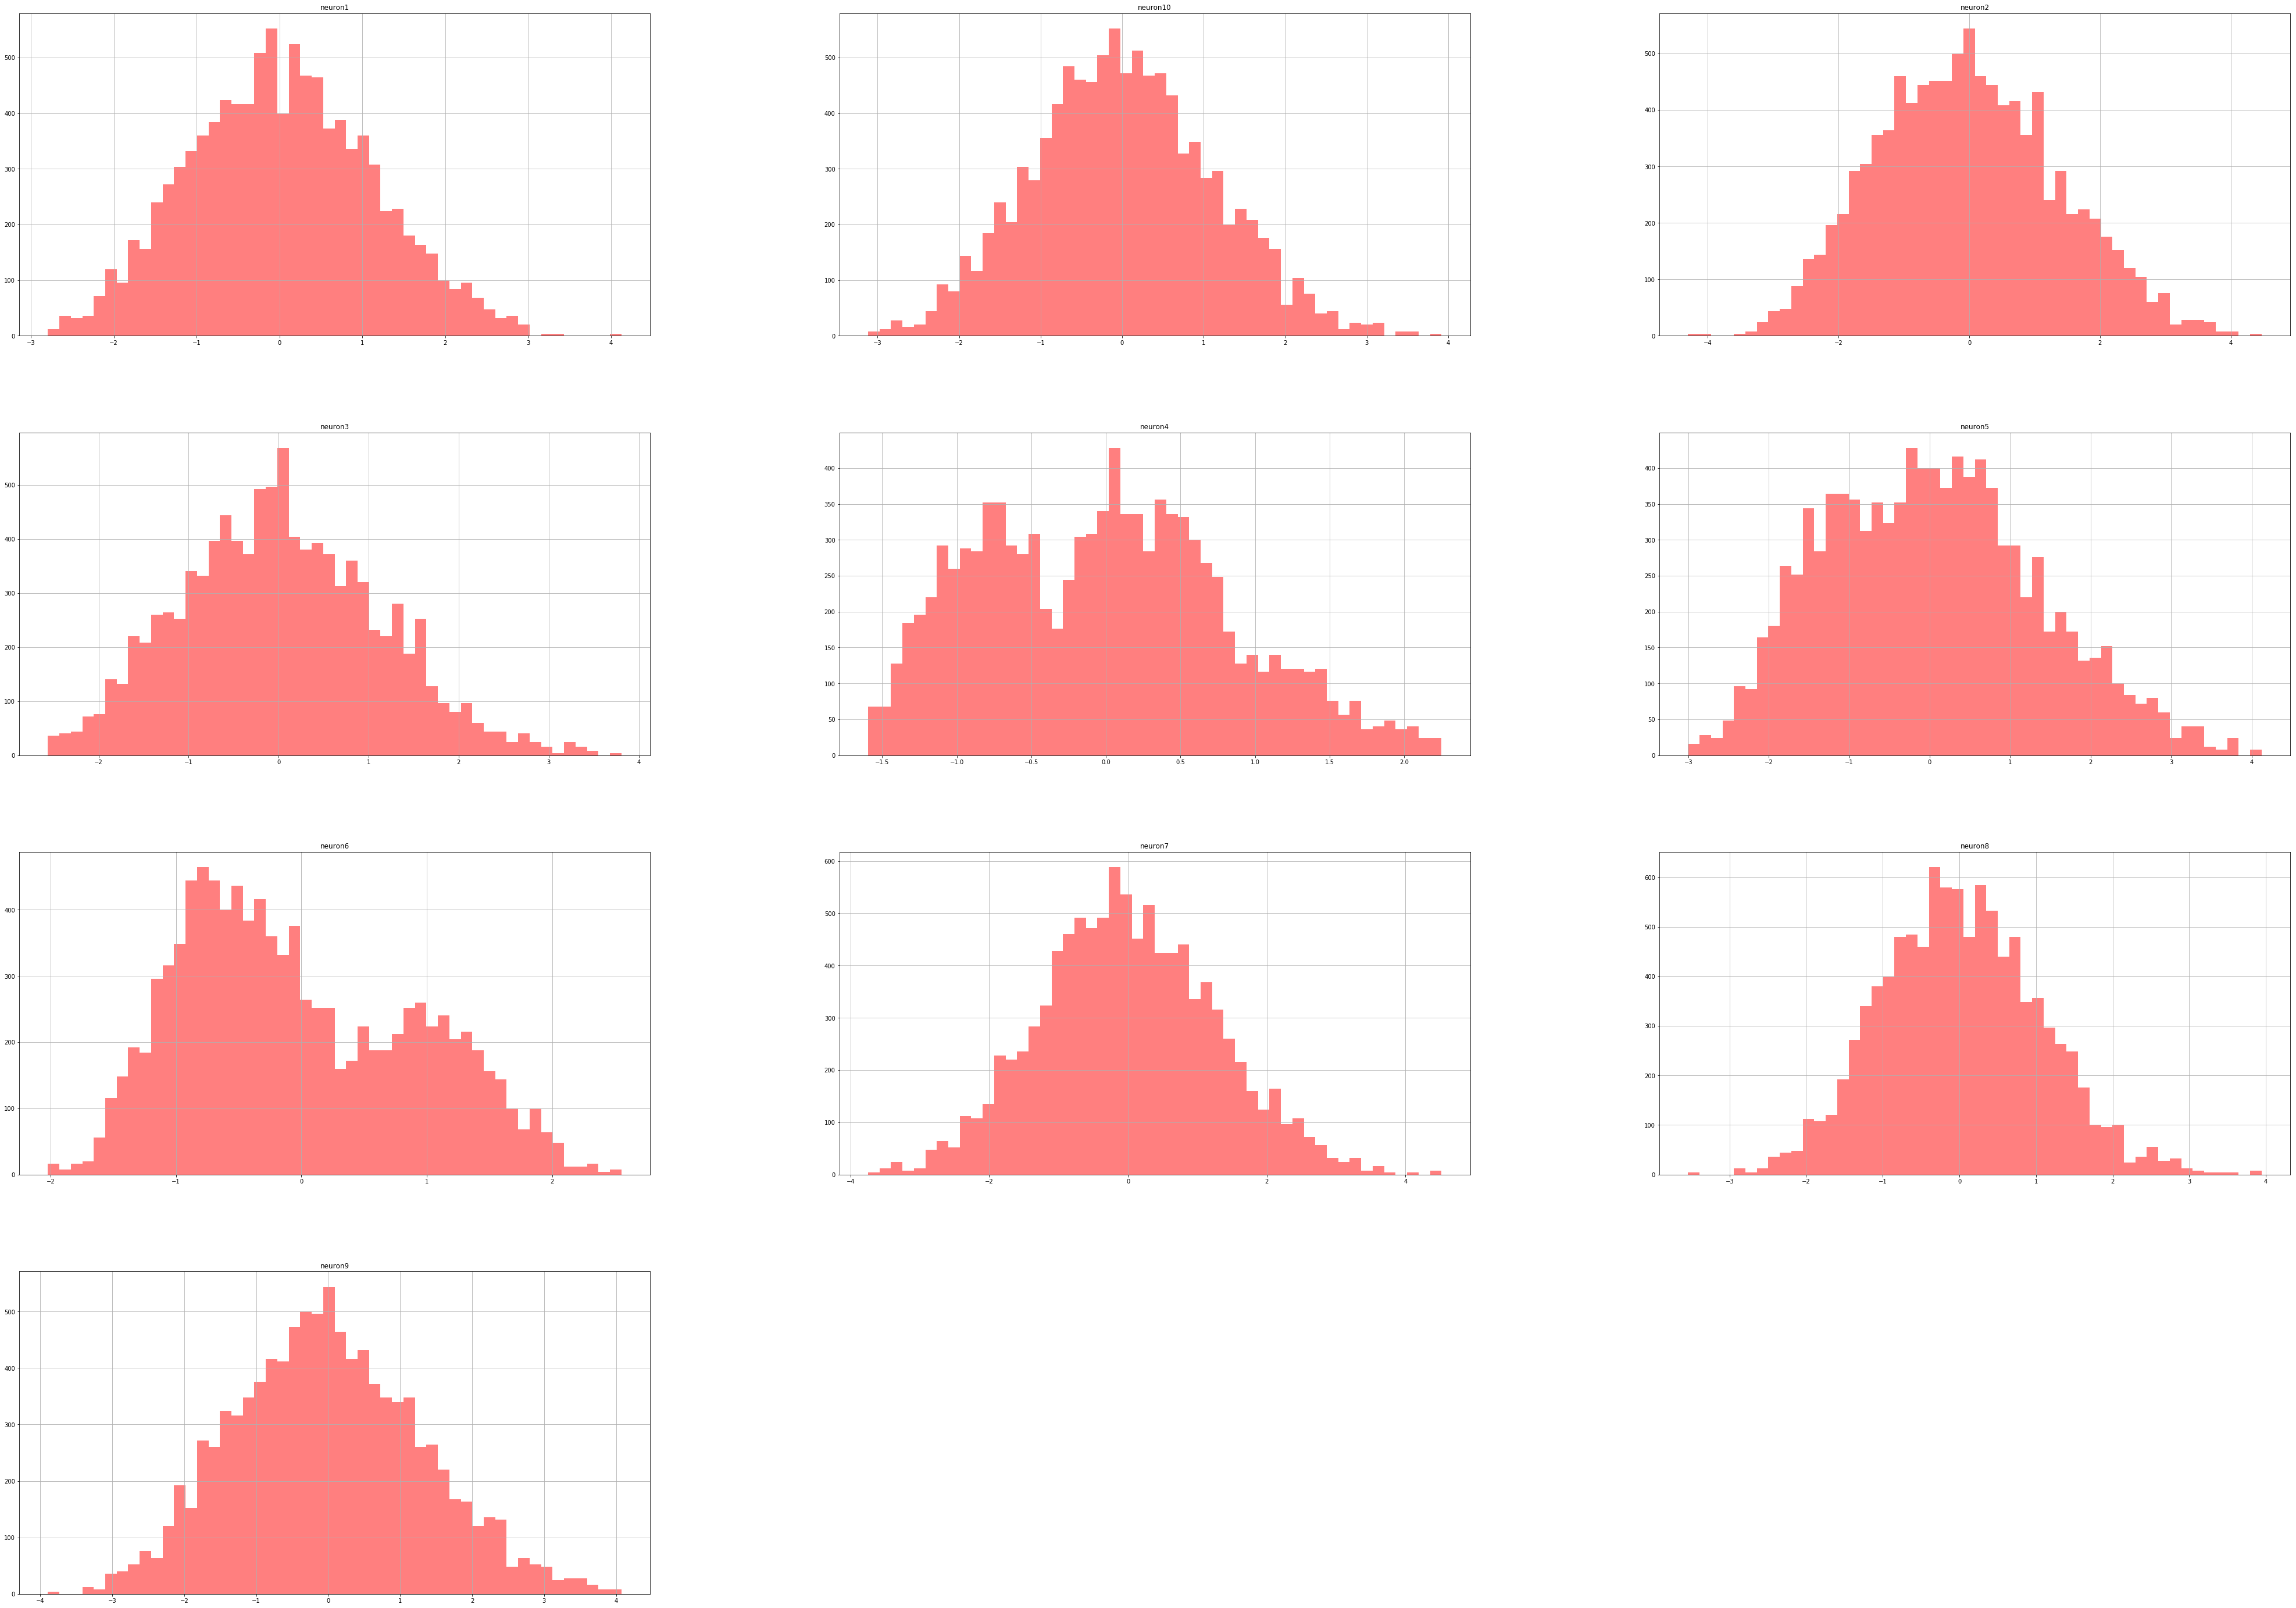

In [21]:
resampled_df = Resampler.shuffle(10000, drd46_fe.neuron_concated_behavior, drd46_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
resampled_df.hist(alpha=0.5, color='red', bins=50, figsize=(70, 50));

In [22]:
drd46_classified_neurons = Resampler.non_normal_neuron_classifier(drd46_fe.auc_df, resampled_df, drd46_real_diff_vals, p_value=0.05, threshold=5)

## Finally, we plot pie charts to visualize the cell selectivity breakdown for:

## DRD87

In [23]:
drd87_cell_dict = deep_classify(drd87_classified_neurons, drd87_real_diff_vals)
plot_pie_chart(drd87_cell_dict, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

## DRD77

In [24]:
drd77_cell_dict = deep_classify(drd77_classified_neurons, drd77_real_diff_vals)
plot_pie_chart(drd77_cell_dict, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

## DRD73

In [25]:
drd73_cell_dict = deep_classify(drd73_classified_neurons, drd73_real_diff_vals)
plot_pie_chart(drd73_cell_dict, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

## DRD46

In [26]:
drd46_cell_dict = deep_classify(drd46_classified_neurons, drd46_real_diff_vals)
plot_pie_chart(drd46_cell_dict, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

## Now we concatenate all of our animals' cell selecitivty dictionaries into one dictionary to easily plot the pie chart for all $137$ neurons.

In [27]:
def concat_dictionaries(*dictionaries):
    all_cells_dictionary = dict()
    key = 1
    for dictionary in dictionaries:
        for value in dictionary.values():
            if key not in all_cells_dictionary:
                all_cells_dictionary[key] = value
                key += 1
                
    return all_cells_dictionary

## For DRD87, DRD77, DRD73, & DRD46, as a collective, we have:

In [28]:
all_cells_dictionary = concat_dictionaries(drd87_cell_dict, drd77_cell_dict, drd73_cell_dict, drd46_cell_dict)
plot_pie_chart(all_cells_dictionary, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

In [29]:
def activity_by_neurons(concated_df, neuron_names, *behaviors, **kwargs):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: DataFrame
        
            A concatenated pandas DataFrame of the neuron activity and 
            the corresponding behavior, for a given animal.
        
        neuron_names: list
        
            The names of the neurons whose rates are to be computed.
        
        behaviors: 
            
            The behaviors for which to compute the activity rates. 
        
        frame_rate: int, optional
        
            The framerate to multiply the activity rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    frame_rate = kwargs.get("frame_rate", None)
    if frame_rate is None:
        warnings.warn("You did not specify a frame rate, so a frame rate"
                      + " of 10 will be utilized in the computation", Warning)
        frame_rate = 10
        
    activity_df = pd.DataFrame(columns=behaviors)
    
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

In [30]:
import plotly
import plotly.graph_objs as go

def plot_activity_rates(activity_rates_df, **kwargs):
    """Wrapper function for Plotly Bar Charts
        
        This function wraps the Plotly library Bar Chart plotting functionality
        in order to quickly and easily create a bar plot for 
    
    Args:
        activity_rates_df: DataFrame
        
            The pandas DataFrame with all the neuron activity means,
            for corresponding behaviors
            
        title: str, optional
        
            The title of the bar plot, to be displayed above the plot,
            default is "Title Goes Here".
        
        color: str, optional
            
            The color of the bar plot to be plotted, e.g., "rgb(10,10,10)",
            default is "rgb(10,10,200)".
    """
    x = [beh for beh in activity_rates_df.columns]
    y = [activity_rates_df[behavior].mean() for behavior in activity_rates_df.columns]

    title = kwargs.get("title", "Title Goes Here")
    color = kwargs.get("color", "rgb(10,10,200)")
    trace1 = go.Bar(
        x=x,
        y=y,
        text=y,
        marker=dict(
            color=color
        ),
        opacity=0.7
    )

    data = [trace1]
    layout = go.Layout(
        title=title,
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

In [32]:
def get_continuous_beh_dfs(feature_extractor, behavior, **kwargs):
    seconds = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)
    dataframes = list()
    
    continuous_beh = dict()
    for row in feature_extractor.neuron_concated_behavior.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= seconds*framerate:

                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]

                dataframes.append(feature_extractor.neuron_concated_behavior.iloc[begin:end])

                continuous_beh.clear()
            else:
                continuous_beh.clear()
                
    return dataframes

In [33]:
def get_rates_for_cont_beh(feature_extractor, behavior, seconds):
    dataframes = get_continuous_beh_dfs(feature_extractor, behavior, seconds=seconds)
    
    rates = list()
    for df in dataframes:
        activity_rates_df = activity_by_neurons(df, feature_extractor.auc_df.columns, behavior)
        rates.append(activity_rates_df[behavior].mean())
        
    return rates, dataframes

In [40]:
def sort_rates_chronological(feature_extractor, open_arms_dataframes, closed_arms_dataframes):
    i = 0
    j = 0
    rates = list()
    markers_on = list()

    while i < len(open_arms_dataframes):
        if open_arms_dataframes[i].index.values[-1] < closed_arms_dataframes[j].index.values[-1]:
            # print("Appended OpenArms dataframe with indices: {}:{}".format(open_arms_dataframes[i].index.values[0], open_arms_dataframes[i].index.values[-1]))
            activity_rates_df = activity_by_neurons(open_arms_dataframes[i], feature_extractor.auc_df.columns, "OpenArms_centerpoint")
            rates.append(activity_rates_df["OpenArms_centerpoint"].mean())
            markers_on.append(len(rates)-1)
            i += 1
        else:
            # print("Appended ClosedArms dataframe with indices: {}:{}".format(closed_arms_dataframes[j].index.values[0], closed_arms_dataframes[j].index.values[-1]))
            activity_rates_df = activity_by_neurons(closed_arms_dataframes[j], feature_extractor.auc_df.columns, "ClosedArms_centerpoint")
            rates.append(activity_rates_df["ClosedArms_centerpoint"].mean())
            j += 1

    while j < len(closed_arms_dataframes):
        # print("Appended ClosedArms dataframe with indices: {}:{}".format(closed_arms_dataframes[j].index.values[0], closed_arms_dataframes[j].index.values[-1]))
        activity_rates_df = activity_by_neurons(closed_arms_dataframes[j], feature_extractor.auc_df.columns, "ClosedArms_centerpoint")
        rates.append(activity_rates_df["ClosedArms_centerpoint"].mean())
        j += 1
    
    return rates, markers_on

In [72]:
import matplotlib.pyplot as plt

def quick_plot(y_axis, figsize, color="blue", title="Title Goes Here", markevery=None):
    plt.figure(figsize=figsize)
    plt.plot(y_axis, color=color, marker='o', linestyle="solid", linewidth=1, markersize=7, markevery=markevery)
    plt.xlabel("Entry")
    plt.ylabel("Rate")
    plt.title(title)
    plt.grid(True)
    plt.show();

## DRD87

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: Warning:

You did not specify a frame rate, so a frame rate of 10 will be utilized in the computation



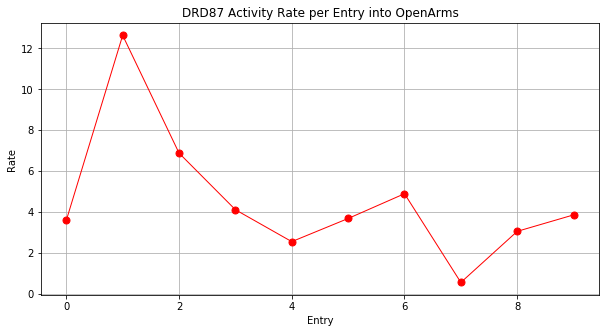

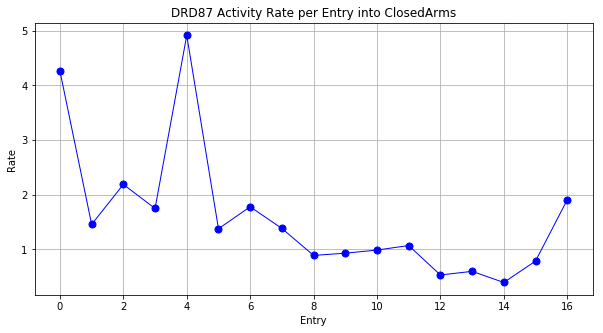

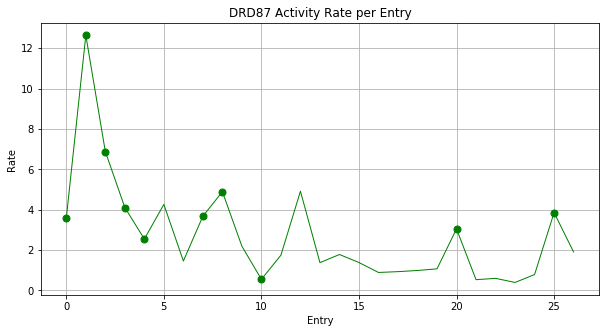

In [73]:
drd87_open_arms_rates, drd87_open_arms_dataframes = get_rates_for_cont_beh(drd87_fe, "OpenArms_centerpoint", 2)
drd87_closed_arms_rates, drd87_closed_arms_dataframes = get_rates_for_cont_beh(drd87_fe, "ClosedArms_centerpoint", 2)

quick_plot(drd87_open_arms_rates, (10, 5), color="red", title="DRD87 Activity Rate per Entry into OpenArms")
quick_plot(drd87_closed_arms_rates, (10, 5), color="blue", title="DRD87 Activity Rate per Entry into ClosedArms")

drd87_all_rates, drd87_markers_on = sort_rates_chronological(drd87_fe, drd87_open_arms_dataframes, drd87_closed_arms_dataframes)

quick_plot(drd87_all_rates, (10, 5), color="green", title="DRD87 Activity Rate per Entry", markevery=drd87_markers_on)

## DRD77

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: Warning:

You did not specify a frame rate, so a frame rate of 10 will be utilized in the computation



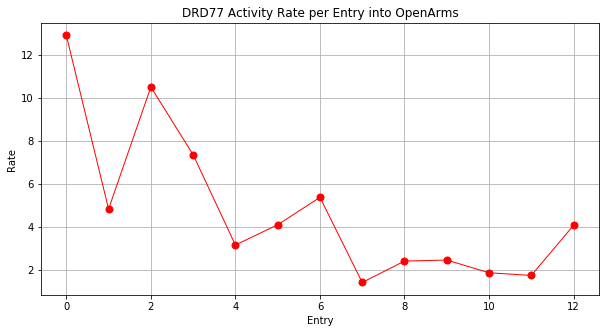

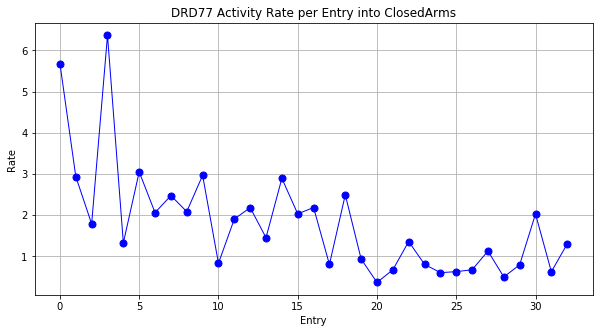

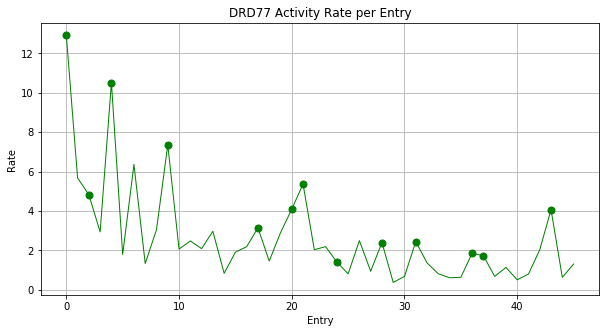

In [74]:
drd77_open_arms_rates, drd77_open_arms_dataframes = get_rates_for_cont_beh(drd77_fe, "OpenArms_centerpoint", 2)
drd77_closed_arms_rates, drd77_closed_arms_dataframes = get_rates_for_cont_beh(drd77_fe, "ClosedArms_centerpoint", 2)

quick_plot(drd77_open_arms_rates, (10, 5), color="red", title="DRD77 Activity Rate per Entry into OpenArms")
quick_plot(drd77_closed_arms_rates, (10, 5), color="blue", title="DRD77 Activity Rate per Entry into ClosedArms")

drd77_all_rates, drd77_markers_on = sort_rates_chronological(drd77_fe, drd77_open_arms_dataframes, drd77_closed_arms_dataframes)

quick_plot(drd77_all_rates, (10, 5), color="green", title="DRD77 Activity Rate per Entry", markevery=drd77_markers_on)

## DRD73

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: Warning:

You did not specify a frame rate, so a frame rate of 10 will be utilized in the computation



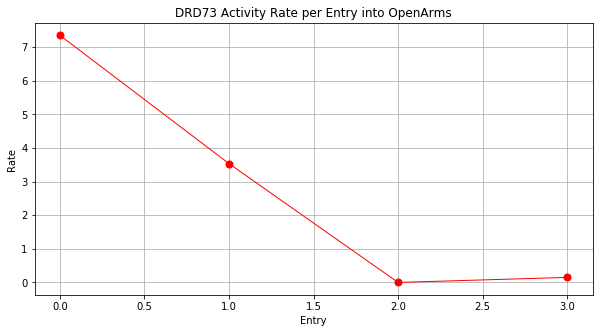

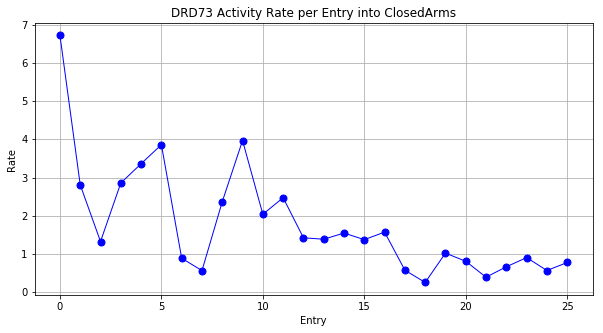

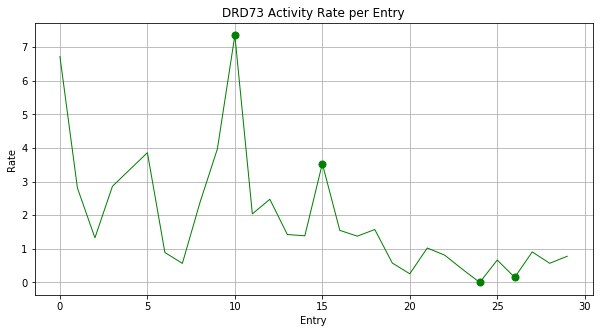

In [75]:
drd73_open_arms_rates, drd73_open_arms_dataframes = get_rates_for_cont_beh(drd73_fe, "OpenArms_centerpoint", 2)
drd73_closed_arms_rates, drd73_closed_arms_dataframes = get_rates_for_cont_beh(drd73_fe, "ClosedArms_centerpoint", 2)

quick_plot(drd73_open_arms_rates, (10, 5), color="red", title="DRD73 Activity Rate per Entry into OpenArms")
quick_plot(drd73_closed_arms_rates, (10, 5), color="blue", title="DRD73 Activity Rate per Entry into ClosedArms")

drd73_all_rates, drd73_markers_on = sort_rates_chronological(drd73_fe, drd73_open_arms_dataframes, drd73_closed_arms_dataframes)

quick_plot(drd73_all_rates, (10, 5), color="green", title="DRD73 Activity Rate per Entry", markevery=drd73_markers_on)

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: Warning:

You did not specify a frame rate, so a frame rate of 10 will be utilized in the computation



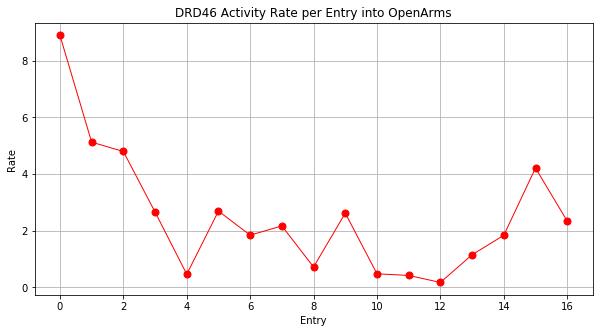

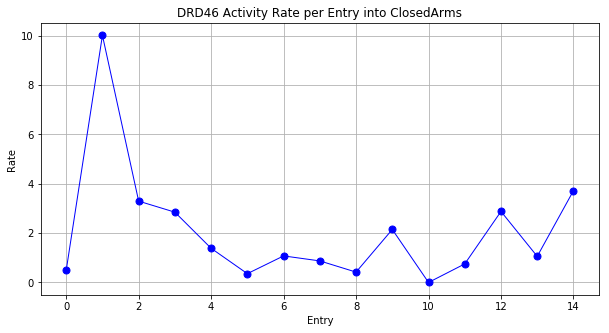

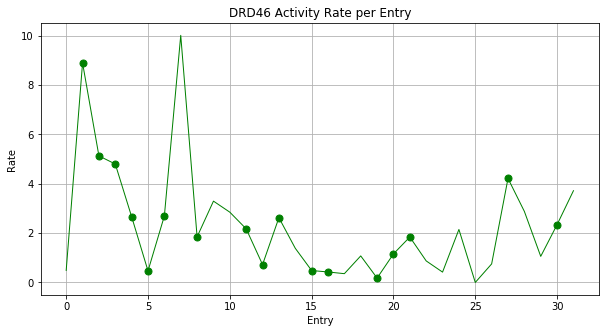

In [76]:
drd46_open_arms_rates, drd46_open_arms_dataframes = get_rates_for_cont_beh(drd46_fe, "OpenArms_centerpoint", 2)
drd46_closed_arms_rates, drd46_closed_arms_dataframes = get_rates_for_cont_beh(drd46_fe, "ClosedArms_centerpoint", 2)

quick_plot(drd46_open_arms_rates, (10, 5), color="red", title="DRD46 Activity Rate per Entry into OpenArms")
quick_plot(drd46_closed_arms_rates, (10, 5), color="blue", title="DRD46 Activity Rate per Entry into ClosedArms")

drd46_all_rates, drd46_markers_on = sort_rates_chronological(drd46_fe, drd46_open_arms_dataframes, drd46_closed_arms_dataframes)

quick_plot(drd46_all_rates, (10, 5), color="green", title="DRD46 Activity Rate per Entry", markevery=drd46_markers_on)